In [1]:
from firedrake import *
from firedrake.pyplot import plot

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


from Network import Net, NeuralNetworkTrainer
from BurgersSolver import BurgersSolver

In [2]:
class BurgersTrainDataset(Dataset):
    def __init__(self, params, N=100):
        burgers = BurgersSolver(**params)

        self.data = []
        self.targets = []
        for i in range(N):
            pcg = PCG64(seed=i)
            rg = Generator(pcg)
            # TODO: replace with gaussian field as below
            
            f_rand = rg.normal(burgers.space)
            f_target = burgers.solve(f_rand)

            self.data.append(f_rand.dat.data)
            self.targets.append(f_target.dat.data)


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]


class TestDataset(Dataset):
    def __init__(self, ):
        pass

    def __len__(self):
        pass
    
    def __getitem__(self, index):
        pass

In [3]:
params = {
    "n": 100,
    "length": 2,
    "nu": 1e-2,
    "degree": 2,
    "t_end": 1
}

burgers_dataset = BurgersTrainDataset(params, N=5)

Time Step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 100/100 [0:00:00]
Time Step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 100/100 [0:00:00]
Time Step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 100/100 [0:00:00]
Time Step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 100/100 [0:00:00]
Time Step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 100/100 [0:00:00]


## Creating gaussian field

In [4]:
def gaussian_field(cg_space, dg_space, cell_area, d=25., s=625., seed=12345):
    pcg = PCG64(seed=seed)
    rg = Generator(pcg)
    
    w = rg.normal(dg_space)
    w.assign(w/(cell_area**2))
    
    v_func = TestFunction(cg_space)
    u_func = TrialFunction(cg_space)

    a = d*u_func * v_func * dx + dot(grad(u_func), grad(v_func)) * dx
    F = s*w * v_func * dx

    uh = Function(cg_space)
    solve(a == F, uh)

    v_func = TestFunction(cg_space)
    u_func = TrialFunction(cg_space)
    
    a = d*u_func * v_func * dx + dot(grad(u_func), grad(v_func)) * dx
    F = v_func * uh * dx
    
    uh_2 = Function(cg_space)
    solve(a == F, uh_2)

    return uh_2

In [16]:
import matplotlib.pyplot as plt
from numpy.random import randint

seed = randint(1000)
d, s = 25, 625
params = {
    "n": 100,
    "length": 1,
    "nu": 1e-2,
    "degree": 2,
    "t_end": 1
}
cell_area = params["length"]/params["n"]


burgers = BurgersSolver(**params)
cg_space = FunctionSpace(burgers.mesh, "CG", degree=1)
dg_space = FunctionSpace(burgers.mesh, "DG", degree=0)

gf = gaussian_field(cg_space, dg_space, cell_area, d=d, s=s, seed=seed)

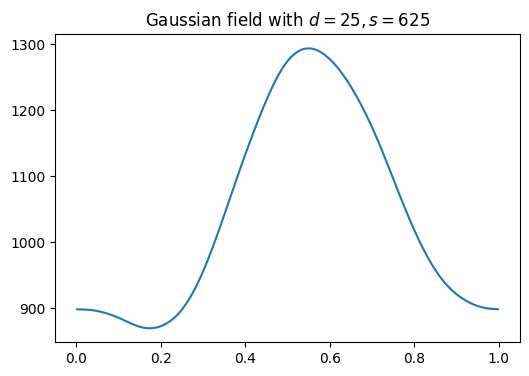

In [17]:
fig, axes = plt.subplots(1, figsize=(6, 4))

axes.set_title(f"Gaussian field with $d={d}, s={s}$")
plot(gf, axes=axes)

In [18]:
N = 2000
d = 25
s = 625

avg_gf = Function(cg_space)
for _ in range(N):
    seed = randint(10000)
    
    gf = gaussian_field(cg_space, dg_space, cell_area, d=d, s=s, seed=seed)
    avg_gf += gf

avg_gf.assign(avg_gf/N)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fa7077a4280>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 9105)), 14171)

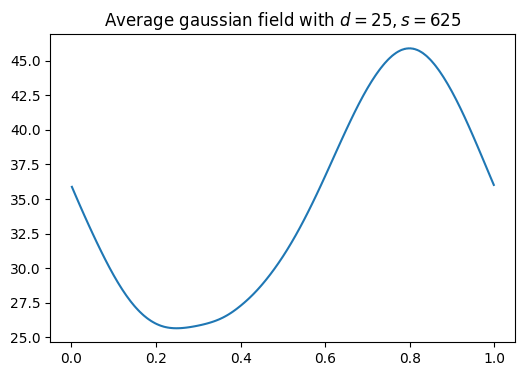

In [19]:
fig, axes = plt.subplots(1, figsize=(6, 4))
axes.set_title(f"Average gaussian field with $d={d}, s={s}$")
plot(avg_gf, axes=axes)